In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import *

import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.
perc_step = 5

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [9]:
# import sea_mask
# if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
#     sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')

In [21]:
###   RETRIEVE TOTAL PRESSURE 

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


pres = (pres+pres_base)/100.                # hectoPascals
pres = pres.where(sea_mask_modified, drop=False)

del pres_base

In [7]:
QCLOUD = xr.open_dataset(wrf_files[files_ls.index('QCLOUD.nc')])
dx, dy = QCLOUD.attrs['DX'], QCLOUD.attrs['DY']
QCLOUD = QCLOUD['QCLOUD'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))#.groupby('time_counter.day').mean()
QCLOUD = QCLOUD.where(sea_mask_modified, drop=False)

In [8]:
qcloud_percell = -(QCLOUD*1000.)*pres.diff(dim=1)*dx*dy/9.81
del pres

In [9]:
qcloud_percell.name='qcloud_percell'
qcloud_percell.attrs['long_name'] = 'Grams of liquid cloud water in every gridbox'
qcloud_percell.attrs['units'] = 'g'

In [ ]:
qcloud_percell = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')

In [31]:
#LWP_lowTropo = qcloud_percell['qcloud_percell'].where(pres>=800).sum(dim='lev_M')
LWP_total = qcloud_percell['qcloud_percell'].sum(dim='lev_M')

In [32]:
LWP_total.name = 'LWP_total'
LWP_total.attrs['long_name'] = 'Column integrated QCLOUD (in grams), total height'
LWP_total.attrs['units'] = 'grams'


In [33]:
qcloud_percell['LWP_total'] = LWP_total

In [34]:
qcloud_percell

<xarray.Dataset>
Dimensions:         (time_counter: 232, y_grid_M: 546, x_grid_M: 573, lev_M: 39)
Coordinates:
  * time_counter    (time_counter) datetime64[ns] 2020-02-01T01:30:00 ... 202...
    nav_lon_grid_M  (y_grid_M, x_grid_M) float32 ...
    nav_lat_grid_M  (y_grid_M, x_grid_M) float32 ...
  * lev_M           (lev_M) float32 1.0 2.0 3.0 4.0 5.0 ... 36.0 37.0 38.0 39.0
Dimensions without coordinates: y_grid_M, x_grid_M
Data variables:
    qcloud_percell  (time_counter, lev_M, y_grid_M, x_grid_M) float32 nan ......
    LWP_lowTropo    (time_counter, y_grid_M, x_grid_M) float32 0.0 0.0 ... 0.0
    LWP_total       (time_counter, y_grid_M, x_grid_M) float32 0.0 0.0 ... 0.0

In [24]:
LWP_lowTropo.name = 'LWP_lowTropo'
LWP_lowTropo.attrs['long_name'] = 'Column integrated QCLOUD (in grams) below 800hPa'
LWP_lowTropo.attrs['units'] = 'grams'

qcloud_percell['LWP_lowTropo'] = LWP_lowTropo  ## this after that qcloud_percell has been turned into dataset


# LWP_lowTropo = xr.DataArray(
#     data=LWP_lowTropo,
#     dims=['time_counter', 'lev_M', 'y_grid_M', 'x_grid_M'],
#     coords={'time': time},
#     attrs={'units': 'example_units', 'long_name': 'Example Variable'}
# )

In [35]:
qcloud_percell.to_netcdf(path='/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')

DRAW DOWN VERTICAL DISTRIBUTIONS FOR QCLOUD_PRECELL

In [4]:
qcloud_percell = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')

## DAILY
qcloud_percell = qcloud_percell['qcloud_percell'].groupby('time_counter.day').mean()

In [7]:
qcloud_percell = qcloud_percell.groupby('time_counter.day').mean()

In [15]:
dsst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_3h_feb.nc')
dsst = dsst['dSST'].where(sea_mask_modified, drop=False)

## DAILY
dsst = dsst[::3,:,:]  #dsst.groupby('time_counter.day').mean()

In [22]:
perc_step = 5;  nbins=20

pdist_dsst, pdist_qc, pstd_qc, pstderr_qc, pnpoints_qc, ppvalue_qc_sub = \
dist_3d_subsample(dsst.values, qcloud_percell.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 9072882 but corresponding boolean dimension is 24402924

# HOW MUCH OF TOTAL LWP IS DUE TO LOW TROPOSPHERIC LWP?

In [82]:
## import LWP_lowTropo
LWP_lowTropo = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')
LWP_lowTropo = LWP_lowTropo['LWP_lowTropo'].where(sea_mask_modified, drop=False)

In [83]:
lwp_total = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')
lwp_total = lwp_total['LWP_total'].where(sea_mask_modified, drop=False)

In [86]:
ratio = LWP_lowTropo.values/lwp_total.values
# ratio = ratio.where(ratio.values>0, other=np.nan, drop=False)

/venus/tesi_ale/img_EU/QCLOUD/map_LWPlow_feb_SMOC3.png


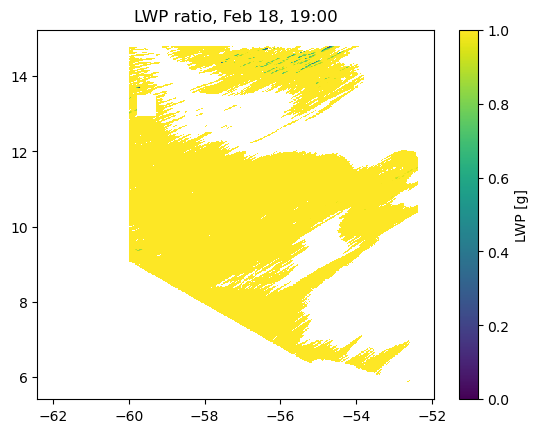

In [89]:
step = int(150)

time = ['01:00', '04:00', '07:00', '10:00', '13:00', '16:00', '19:00', '22:00']
day = int(step/8) ; index_time = step%8

plt.pcolormesh(lon_M, lat_M, ratio[step,:,:], vmax=1)
plt.colorbar(label='LWP [g]')
plt.title(f'LWP ratio, Feb {day}, {time[index_time]}')

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'map_LWPlow_feb_SMOC3.png'
# plt.savefig(filename)
print(filename)
del filename

In [90]:
ratio_nanless = ratio[~np.isnan(ratio)]

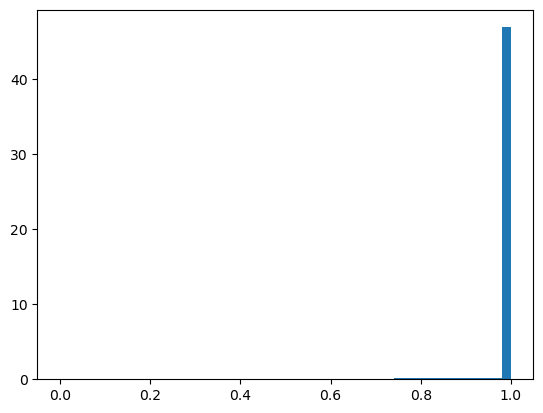

In [98]:
counts = plt.hist(ratio_nanless, bins=50, density=True)

/venus/tesi_ale/img_EU/QCLOUD/hist_ratio_LWPlowTropo-total.png


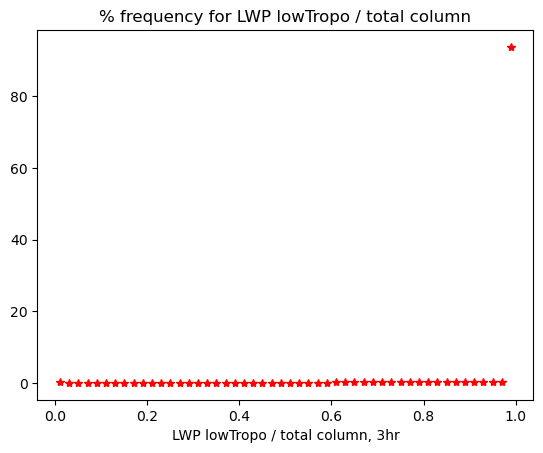

In [102]:
rel_freq = counts[0]/np.sum(counts[0])*100
bins = counts[1];  bins = 0.5*(bins[0:-1]+bins[1:])
plt.plot(bins, rel_freq, 'r*')
plt.title('% frequency for LWP lowTropo / total column')
plt.xlabel('LWP lowTropo / total column, 3hr')

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'hist_ratio_LWPlowTropo-total.png'
plt.savefig(filename)
print(filename)
del filename

# Plotting starts from here

In [ ]:
# retrieve SST and PBLH

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.



In [6]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2019-12-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [7]:
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))#.groupby('time_counter.day').mean()            
sst = sst.where(sea_mask_modified, drop=False)
sst = sst[::3,:,:]   # 3h data

# FULL FIELDS

In [8]:
## import LWP_lowTropo
LWP_lowTropo = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')
LWP_lowTropo = LWP_lowTropo['LWP_lowTropo'].where(sea_mask_modified, drop=False)

/venus/tesi_ale/img_EU/QCLOUD/scatter_sst_LWPlow_feb.png


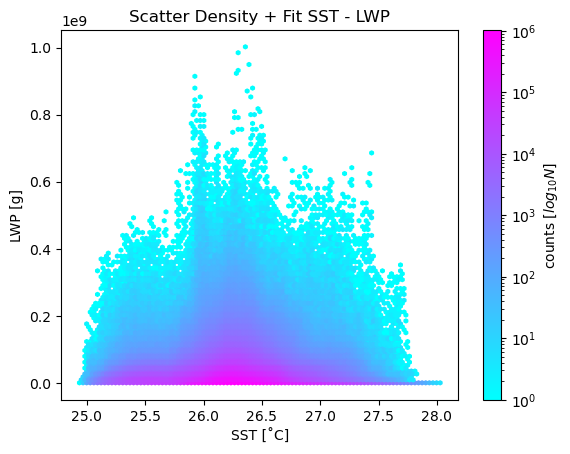

In [37]:

x = sst.values-273.15
y = -LWP_lowTropo.values

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='Scatter Density + Fit SST - LWP'
xlabel='SST [˚C]'
ylabel='LWP [g]'
    

fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_sst_LWPlow_feb.png' # if dsst else path_img + 'scatterFIT_sst_RH_feb.png'
# plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/QCLOUD/map_LWPlow_feb_SMOC3.png


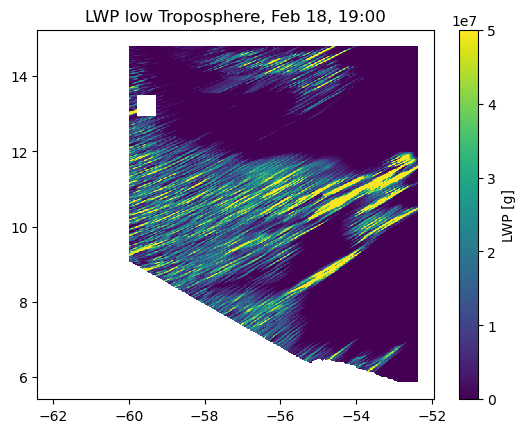

In [53]:
step = int(150)

time = ['01:00', '04:00', '07:00', '10:00', '13:00', '16:00', '19:00', '22:00']
day = int(step/8) ; index_time = step%8

plt.pcolormesh(lon_M, lat_M, -LWP_lowTropo[step,:,:], vmax=0.5e8)
plt.colorbar(label='LWP [g]')
plt.title(f'LWP low Troposphere, Feb {day}, {time[index_time]}')

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'map_LWPlow_feb_SMOC3.png'
# plt.savefig(filename)
print(filename)
del filename

# ANOMALIES

In [33]:
fst = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_fst.npy')
snd = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_snd.npy')
trd = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_trd.npy')
lst = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_lst.npy')


dsst = np.concatenate([fst, snd, trd, lst], axis=0)

dsst = xr.DataArray(
    data=dsst,
    dims=['time_counter', 'y_grid_M', 'x_grid_M'],
    attrs={'units': 'K', 'long_name': '3hr SST anomalies at 200km with first mask'}
)

dsst.name = 'dSST'

ds = dsst.to_dataset(name='dSST')
ds.to_netcdf('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_3h_feb.nc')

In [26]:
dsst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_3h_feb.nc')
dsst = dsst['dSST'].where(sea_mask_modified, drop=False)

/venus/tesi_ale/img_EU/QCLOUD/scatter_dsst_LWPlow_feb.png


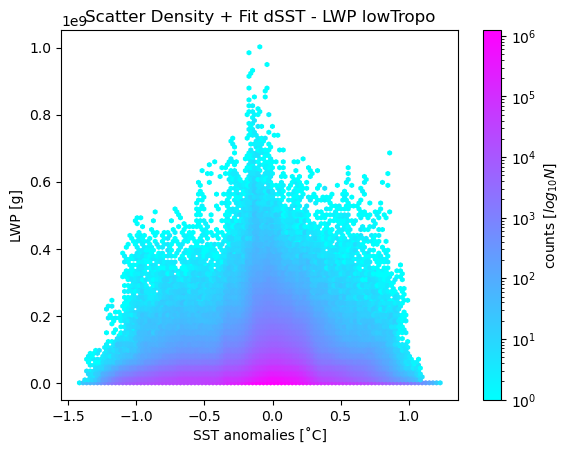

In [38]:

x = dsst.values
y = -LWP_lowTropo.values

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='Scatter Density + Fit dSST - LWP lowTropo'
xlabel='SST anomalies [˚C]'
ylabel='LWP [g]'
    

fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_dsst_LWPlow_feb.png' #if dsst else path_img + 'scatterFIT_sst_RH_feb.png'
# plt.savefig(filename)
print(filename)
del filename

ANOMALIES OF LWP 

In [14]:
s = 100

lwp = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')
lwp = -lwp['LWP_lowTropo']

dLWP = np.zeros(lwp.shape)

for t in range(0,lwp.shape[0]):
    if t % 10 == 0:
        print(t)
    
    lwp_ave = gm.nan_gaussian_filter(lwp[t].values,s)                             
    dLWP[t] = lwp[t] - lwp_ave
    
del lwp

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


In [29]:
dLWP = xr.DataArray(
    name='dLWP',
    data=dLWP,
    dims=['time_counter', 'y_grid_M', 'x_grid_M'],
    attrs={'units': 'K', 'long_name': '3hr SST anomalies at 200km with first mask'}
)

dLWP = dLWP.where(sea_mask_modified, drop=False)

/venus/tesi_ale/img_EU/QCLOUD/scatter_dsst_dLWPlow_feb.png


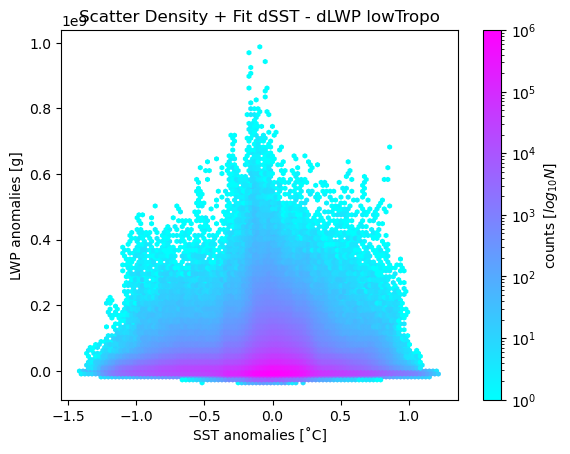

In [39]:
x = dsst.values
y = dLWP.values

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='Scatter Density + Fit dSST - dLWP lowTropo'
xlabel='SST anomalies [˚C]'
ylabel='LWP anomalies [g]'
    

fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_dsst_dLWPlow_feb.png' 
# plt.savefig(filename)
print(filename)
del filename



In [19]:
# PBLH
'''PBLH_dec = ds_hourly['PBLH'].sel(time_counter=slice('2019-12-01T01:30:00.000000000', '2020-01-01T01:30:00.000000000')).groupby('time_counter.day').mean()            
PBLH_jan = ds_hourly['PBLH'].sel(time_counter=slice('2020-01-01T01:30:00.000000000', '2020-02-01T01:30:00.000000000')).groupby('time_counter.day').mean()'''            
PBLH_feb = ds_hourly['PBLH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000')).groupby('time_counter.day').mean()            

PBLH_day = PBLH_feb   #xr.concat([PBLH_dec, PBLH_jan, PBLH_feb], dim='day')

del PBLH_feb  #  PBLH_dec, PBLH_jan, PBLH_feb 

In [20]:
PBLH_day = PBLH_day.where(sea_mask, drop=False)

In [ ]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask, drop=False).values

In [ ]:
buoya = sst_day - T2

In [ ]:
# distributions QCLOUD data - full dataset

In [15]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

perc_step = 5
nbins = int(100/perc_step) # Number of bins.

In [35]:
# percentiles
# x,y,perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top, perc_fixbin
# dist_x, dist_y, std_y, stderr_y, npoints_y, pvalue_y, pvalue_y_sub


pdist_sst, pdist_QCLOUD, pstd_QCLOUD, pstderr_QCLOUD, pnpoints_QCLOUD, ppvalue_QCLOUD_sub = \
dist_3d_subsample(sst_day.values, QCLOUD.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [36]:
## save data
p_cl_sst = [pdist_sst, pdist_QCLOUD, pstd_QCLOUD, pstderr_QCLOUD, pnpoints_QCLOUD, ppvalue_QCLOUD_sub]
my_save_data('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/pdistrs_QCLOUD_SST_day_feb.npy', p_cl_sst)

In [23]:
'''# bins
dist_sst, dist_QCLOUD, std_QCLOUD, stderr_QCLOUD, npoints_QCLOUD, pvalue_QCLOUD_sub = \
dist_3d_subsample(sst_day.values, QCLOUD.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='fb')'''

0
10
20
30


In [37]:
#  PBLH distrib
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_SST_day_feb.npy', 'rb') as f:
    pdist_sst = np.load(f)
    pdist_PBLH_sst = np.load(f)
    f.close()


# # perc
# pdist_sst, pdist_PBLH_sst, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH = distrib_2d(sst_day.values, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin = 'perc')

'''# bins
dist_sst, dist_PBLH_sst, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH = distrib_2d(sst_day.values, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin = 'fb')'''

"# bins\ndist_sst, dist_PBLH_sst, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH = distrib_2d(sst_day.values, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin = 'fb')"

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/pdist_SST_QCLOUD_lowtropo_day_feb.png


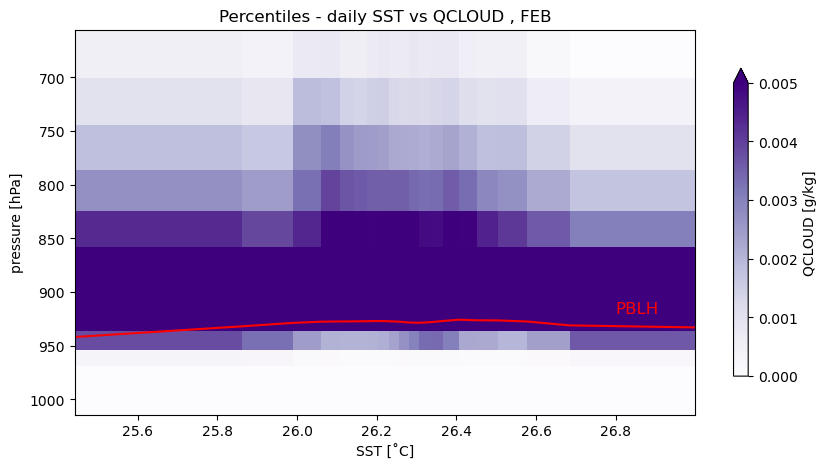

In [41]:
p_level_plot = int(18)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_sst if perc else dist_sst
var = pdist_QCLOUD[0:p_level_plot] if perc else dist_QCLOUD[0:p_level_plot]
minval = 0. ; maxval = 0.005

fig, ax1 = plt.subplots(figsize=(10, 5))  ; ax1.invert_yaxis()
p1 = ax1.pcolormesh(x-273.15, mean_vert_pres[0:p_level_plot], var*1000, vmin=minval, vmax=maxval, cmap='Purples') #pdist_dqvapor_dsst_day
ax1.set_xlabel('SST [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily SST vs QCLOUD , FEB')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='max')  
cbar.set_label('QCLOUD [g/kg]')

var_pbl = pdist_PBLH_sst if perc else dist_PBLH_sst
ax1.plot(x-273.15, var_pbl, '-r', linewidth=1.5)
ax1.text(26.8, 920, 'PBLH', fontsize=12, color='r')



# savefig
path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/QCLOUD/daily/bins/DJF/'
filename = path_img + 'pdist_SST_QCLOUD_lowtropo_day_feb.png' #if perc else path_img + 'bins_sst_qcloud_lowtropo_DJF.png'
# plt.savefig(filename)
print(filename)
del filename

In [43]:
# save distributions data
perc = False

path_to_data = '/venus/tesi_ale/results_EU/distributions/DJF/'
filename = path_to_data + 'perc/' if perc else path_to_data + 'fix_bin/'

# pdist_sst, pdist_QCLOUD
# save: choose each time a var to save
x = pdist_QCLOUD if perc else dist_QCLOUD
filename += 'QCLOUD/pdist_QCLOUD_sst_day_DJF.npy' if perc else 'QCLOUD/dist_QCLOUD_sst_day_DJF.npy'

print(filename)
#np.save(filename, x)
del filename

/venus/tesi_ale/results_EU/distributions/DJF/fix_bin/QCLOUD/dist_QCLOUD_sst_day_DJF.npy


In [13]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

with open('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/dQCLOUD_day_feb.npy', 'rb') as f:
    dQCLOUD_day = np.load(f)

"with open('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/dQCLOUD_day_feb.npy', 'rb') as f:\n    dQCLOUD_day = np.load(f)"

In [11]:
# compute anomalies daily data
s = 100

'''dsst_day = np.zeros(sst_day.shape)'''
dQCLOUD_day = np.zeros(QCLOUD.values.shape)
'''dPBLH_day = np.zeros(PBLH_day.shape)'''


for t in range(0,QCLOUD.values.shape[0]):
    if t % 10 == 0:
        print(t)
    
    '''sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    pbl_ave = gm.nan_gaussian_filter(PBLH_day[t],s)                             
    dPBLH_day[t] = PBLH_day[t] - pbl_ave'''
    
    for h in range(0,QCLOUD.values.shape[1]):
        QCLOUD_ave = gm.nan_gaussian_filter(QCLOUD[t,h],s)                             
        dQCLOUD_day[t,h] = QCLOUD[t,h] - QCLOUD_ave

0
10
20


In [12]:
## save anomalies
my_save_data('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/dQCLOUD_day_feb.npy', [dQCLOUD_day])

In [ ]:
# compute distributions of ANOMALIES

In [16]:
# PERC DISTRIBUTION dQCLOUD vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent

pdist_dsst_day, pdist_dQCLOUD_day, pstd_dQCLOUD_day, pstderr_dQCLOUD_day, pnpoints_dQCLOUD, ppvalue_dQCLOUD_day_sub = \
dist_3d_subsample(dsst_day, dQCLOUD_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [17]:
## SAVE DQCLOUD
p_dqcl_dsst = [pdist_dsst_day, pdist_dQCLOUD_day, pstd_dQCLOUD_day, pstderr_dQCLOUD_day, pnpoints_dQCLOUD, ppvalue_dQCLOUD_day_sub]
my_save_data('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/pdistrs_dQCLOUD_dSST_day_feb.npy', p_dqcl_dsst)

In [27]:
# BIN DISTRIBUTION dQCLOUD vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent

'''dist_dsst_day, dist_dQCLOUD_day, std_dQCLOUD_day, stderr_dQCLOUD_day, npoints_QCLOUD, pvalue_dQCLOUD_day_sub = \
dist_3d_subsample(dsst_day, dQCLOUD_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='fb')'''

0
10
20
30


In [20]:
# DISTRIBUTION PBLH  

with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_dSST_day_feb.npy', 'rb') as f:
    pdist_dsst = np.load(f)
    pdist_PBLH_dsst = np.load(f)
    # other data missing
    f.close()


'''perc_step = 5
nbins = int(100/perc_step) # Number of bins.

# # dPBLH vs dSST - DAILY
# pdist_dsst_day, pdist_dPBLH_day, pstd_dPBLH_day, pstderr_dPBLH_day, pnpoints_dPBLH_day, ppvalue_dPBLH_day = \
# distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, 'perc')

# dSST vs PBLH 
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin='perc')'''

'''# BINS
dist_dsst, dist_PBLH_dsst, std_PBLH_dsst, std_err_PBLH_dsst, npoints_PBLH_dsst, pvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin='fb')'''

"# BINS\ndist_dsst, dist_PBLH_dsst, std_PBLH_dsst, std_err_PBLH_dsst, npoints_PBLH_dsst, pvalue_PBLH_dsst = distrib_2d(dsst_day, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin='fb')"

In [ ]:
#####   PLOTTING ANOMALIES DISTRIBUTIONSSSS   ######

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/pdist_dsst_dqcloud_lowtropo_hatch.png


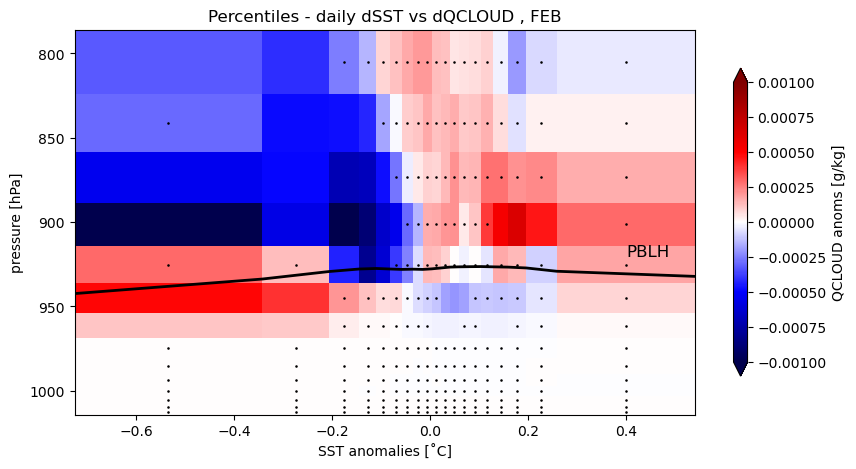

In [34]:
p_level_plot = int(15)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_dsst_day if perc else dist_dsst_day
var = pdist_dQCLOUD_day[0:p_level_plot] if perc else dist_dQCLOUD_day[0:p_level_plot]
minval = -0.001 ; maxval = -minval

fig, ax1 = plt.subplots(figsize=(10, 5))  ;  ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var*1000, vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily dSST vs dQCLOUD , FEB')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('QCLOUD anoms [g/kg]')

var_pbl = pdist_PBLH_dsst if perc else dist_PBLH_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 920, 'PBLH', fontsize=12, color='k')




# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dQCLOUD_day_sub[0:p_level_plot] if perc else pvalue_dQCLOUD_day_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' if perc else '/venus/tesi_ale/img_EU/QCLOUD/daily/bins/FEB/'
filename = path_img + 'pdist_dsst_dqcloud_lowtropo_hatch.png' if perc else path_img + 'bins_dsst_dqcloud_lowtropo_hatch.png'
# plt.savefig(filename)
print(filename)
del filename

In [42]:
# my_save_data('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy', [mean_vert_pres])

In [10]:
#######  LINK BETWEEN    preci_water (dqcloud_sum) vs dsst

<xarray.DataArray 'QCLOUD' (day: 29, lev_M: 39, y_grid_M: 546, x_grid_M: 573)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    nav_lon_grid_M  (y_grid_M, x_grid_M) float32 ...
    nav_lat_grid_M  (y_grid_M, x_grid_M) float32 ...
  * lev_M           (lev_M) float32 1.0 2.0 3.0 4.0 5.0 ... 36.0 37.0 38.0 39.0
  * day             (day) int64 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
Dimensions without coordinates: y_grid_M, x_grid_M

In [16]:
preci_water = QCLOUD.sum(axis=1)      # SBAGLIATO!!!!! OCCHIO AI g/kg_air

In [27]:
# compute anomalies daily data
s = 100

dpreci_water = np.zeros(preci_water.values.shape)

devo_fare_dsst = True
if devo_fare_dsst:
    dsst_day = np.zeros(sst_day.shape)


for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    pw_ave = gm.nan_gaussian_filter(preci_water[t],s)                             
    dpreci_water[t] = preci_water[t] - pw_ave
    
    if devo_fare_dsst:
        sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
        dsst_day[t] = sst_day[t] - sst_ave

    

0
10
20


In [53]:
# SST vs PRECI_WATER    #   x_index = int(0); y_index = int(0)
perc_step = 2
nbins = int(100/perc_step)
popmean = 0.

pdist_sst, pdist_pw_sst, pstd_pw_sst, pstd_err_pw_sst, pnpoints_pw_sst, ppvalue_pw_sst = \
distrib_2d(sst_day.values, preci_water.values, perc_step, nbins, popmean, perc_fixbin='perc')

dist_sst, dist_pw_sst, std_pw_sst, std_err_pw_sst, npoints_pw_sst, pvalue_pw_sst = \
distrib_2d(sst_day.values, preci_water.values, perc_step, nbins, popmean, perc_fixbin='fb')

In [54]:
# dSST vs PRECI_WATER    # x_index = int(1); y_index = int(1)
perc_step = 2
nbins = int(100/perc_step)
popmean = 0.

pdist_dsst, pdist_pw_dsst, pstd_pw_dsst, pstd_err_pw_dsst, pnpoints_pw_dsst, ppvalue_pw_dsst = \
distrib_2d(dsst_day, preci_water.values, perc_step, nbins, popmean, perc_fixbin='perc')

dist_dsst, dist_pw_dsst, std_pw_dsst, std_err_pw_dsst, npoints_pw_dsst, pvalue_pw_dsst = \
distrib_2d(dsst_day, preci_water.values, perc_step, nbins, popmean, perc_fixbin='fb')

In [55]:
# dSST vs dPRECI_WATER  # x_index = int(1); y_index = int(2)
perc_step = 2
nbins = int(100/perc_step)
popmean = 0.

pdist_dsst, pdist_dpw_dsst, pstd_dpw_dsst, pstd_err_dpw_dsst, pnpoints_dpw_dsst, ppvalue_dpw_dsst = \
distrib_2d(dsst_day, dpreci_water, perc_step, nbins, popmean, perc_fixbin='perc')

dist_dsst, dist_dpw_dsst, std_dpw_dsst, std_err_dpw_dsst, npoints_dpw_dsst, pvalue_dpw_dsst = \
distrib_2d(dsst_day, dpreci_water, perc_step, nbins, popmean, perc_fixbin='fb')

In [32]:
pdist_dpw_dsst.shape

(20,)

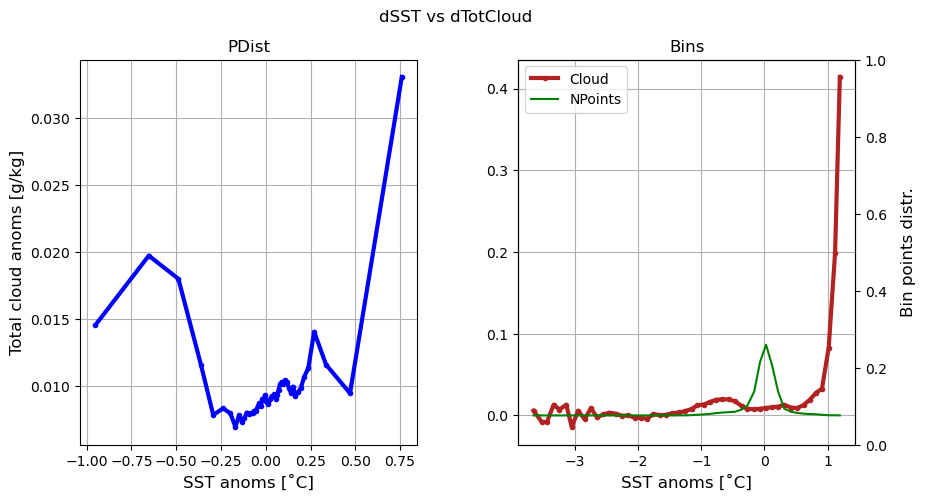

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

x_index = int(1); y_index = int(2)


if x_index == 0 and y_index == 0:
    xlab = 'SST [˚C]'
    ylab = 'Total cloud [g/kg]'
elif x_index == 1 and y_index == 1:
    xlab = 'SST anoms [˚C]'
    ylab = 'Total cloud [g/kg]'
elif x_index == 1 and y_index == 2:
    xlab = 'SST anoms [˚C]'
    ylab = 'Total cloud anoms [g/kg]'
else:
    print('wrong combination')


# PERCENTILES
px_pw = [pdist_sst-273.15, pdist_dsst]
py_pw = [pdist_pw_sst, pdist_pw_dsst, pdist_dpw_dsst]
ax[0].plot(px_pw[x_index], py_pw[y_index]*1000, '.-', color='b', linewidth=3)

ax[0].set_ylabel(ylab, fontsize=12); ax[0].set_xlabel(xlab, fontsize=12); 
ax[0].grid(); ax[0].set_title('PDist')




# FIXED BINS
fbx_pw = [dist_sst-273.15, dist_dsst]
fby_pw = [dist_pw_sst, dist_pw_dsst, dist_dpw_dsst]
fb_points = [npoints_pw_sst, npoints_pw_dsst, npoints_dpw_dsst]
ax[1].plot(fbx_pw[x_index], fby_pw[y_index]*1000, '.-',color='firebrick', linewidth=3, label='Cloud' )
ax[1].set_xlabel(xlab, fontsize=12); 
ax[1].grid(); ax[1].set_title('Bins')

axxx = ax[1].twinx()
ax[1].plot(fbx_pw[x_index], fb_points[y_index]/np.sum(fb_points), '-', color='g', label='NPoints') 
axxx.set_ylabel('Bin points distr.', fontsize=12, labelpad=10)
ax[1].legend()


if x_index == 0 and y_index == 0:
    title = 'Full fields - SST vs TotCloud'
    filename = 'sst_totCloud_daily_FEB_2pc.png'
elif x_index == 1 and y_index == 1:
    title = 'dSST vs TotCloud'
    filename = 'dsst_totCloud_daily_FEB_2pc.png'
elif x_index == 1 and y_index == 2:
    title = 'dSST vs dTotCloud'
    filename = 'dsst_dTotCloud_daily_FEB_2pc.png'
else:
    print('wrong combination')
    
fig.suptitle(title)

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.3)


#plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/daily/2_perc/'+filename)

In [ ]:
### convective rain on?   -> NOPE!

In [30]:
rain = ds_hourly['RAINCV'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
rain = rain.where(sea_mask, drop=False)

In [31]:
tot_rain = rain.sum(dim='time_counter')

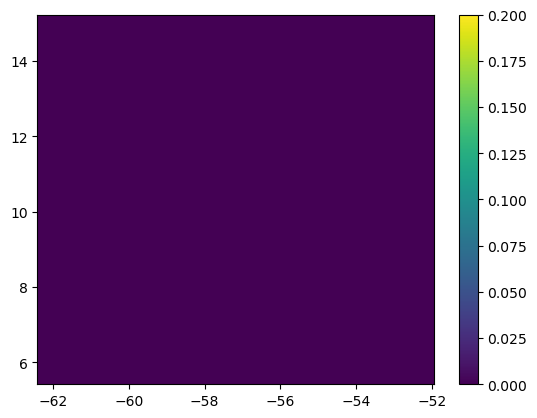

In [32]:
plt.pcolormesh(lon_M, lat_M, tot_rain[:,:], vmin=0., vmax=0.2)
plt.colorbar()

In [ ]:
'''# retrieve vapour pressure
QVAPOR = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
QVAPOR = QVAPOR['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
QVAPOR = QVAPOR.where(sea_mask, drop=False)

vap_pres = mpcalc.vapor_pressure(pres*units.hPa, QVAPOR*units('kg/kg')).to('hPa')
vap_pres = vap_pres.magnitude()   # in hPa

dry_pres = pres-vap_pres

del QVAPOR

# retrieve temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

# full pot_temp field
# = T+T0 , T0 = 300
pot_temp = pot_temp + 300
temperature = pot_temp * ( pres / 1000. )**0.286
del pot_temp

# get dry air density
rho_dry = meteo.rhod(temperature, dry_pres)'''